In [1]:
'''
The purpose of this file is to store functions that we will be referring to in our data gathering process
'''

# we will need packages that allow us to make a GET request
import requests

# importing packages that will allow us to transform our data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# we will need to access files from our system 
import os
import datetime

# importing packages that will allow us to set visual params for our plots
from matplotlib import rc

import seaborn.objects as so

from seaborn import axes_style

In [2]:
# GRABBING API KEY FROM TEXT FILE
def get_api_key(txt_file, key_loc):
    '''
    Purpose is to go into a txt file and grab the EIA API Key needed to make data requests
    '''
    with open(txt_file, 'r') as f:
        lines = f.readlines()
        api_key = lines[key_loc]
        print('successfully grabbed you API Key')

        return api_key
    
# checking that our API Key is printing correctly
api_key = get_api_key(txt_file='eia_api_key.txt', key_loc=1)

# print(api_key)

successfully grabbed you API Key


In [3]:
# TRANSLATING A PARAMS JSON OBJECT BEFORE MAKING A DATA REQUEST
def create_params_obj(series_id, start_period):
    '''
    Purpose is to create our own params object that we can pass in our
    data request. 
    Given some constraints and vars, create a params json object
    '''
    # setting up a variable for todays date
    today = datetime.date.today()
    year_month = today.strftime('%Y-%m')


    # creating the json object that will make the request
    params_object = {
        'frequency':'monthly', # usually we want monthly data from STEO dataset
        'data': [
            'value'            
        ],
        'facets': {
            'seriesId': [
                str(series_id)
            ]
        },
        'start': str(start_period),
        'end': str(year_month),
        'sort': [
            {
                'column': 'period',
                'direction': 'desc'
            }
        ], 
        'offset': 0,
        'length':5000,
    }

    return params_object

In [4]:
# testing to check if our params object works
test_params = create_params_obj(series_id='el_patron', start_period='2020-04')
print(test_params)

{'frequency': 'monthly', 'data': ['value'], 'facets': {'seriesId': ['el_patron']}, 'start': '2020-04', 'end': '2024-03', 'sort': [{'column': 'period', 'direction': 'desc'}], 'offset': 0, 'length': 5000}


In [5]:
# GRABBING DATA FROM EIA OPEN DATA
def grab_steo_data(params_object, api_key):
    '''
    Purpose is to make a request to EIA Open Data API for STEO specific data
    '''
    # this is the base url for STEO
    url = 'https://api.eia.gov/v2/steo/data/'

    # frequency of data, either monthly, quarterly, or annually
    freq = '&frequency=' + str(params_object['frequency'])

    # data type
    d_type = '&data[0]=' + str(params_object['data'][0])

    # this ensures that we sort data by period
    sort = '&sort[0][column]=period'

    # placing our sort order in a descending format
    direction = '&sort[0][direction]=desc'

    # offset, not entirely sure what this is 
    offset = '&offset=0'

    # length of the data that we are requesting, the max that we can request is 5_000
    length = '&length=5000'

    # essentially, if the facets params section of the object has something process it 
    if len(params_object['facets']) > 0:
        facet = f'&facets[seriesId][]={params_object['facets']['seriesId'][0]}'
        start = f'&start={params_object['start']}'

        # concatenating all url segments
        full_url = f'{url}?api_key={api_key}{freq}{d_type}{facet}{start}{sort}{direction}{offset}{length}'

    else:
        start = f'&start={params_object['start']}'

        # concatenating all url segments to create a full url
        full_url = f'{url}?api_key={api_key}{freq}{d_type}{start}{sort}{direction}{offset}{length}' 

        # letting the user know that the facets length was 0 aka that no features were selected
        print(f'facets object length is {len(params_object['facets'])}!')

    # let's check our full url
    # print(full_url)
    
    # we know begin the request process
    request = requests.get(full_url)
    data = request.json()

    # grabbing just the data, stripping the data object from unnecessary stuff
    entries = data['response']['data']

    # converting the data we just grabbed into a df
    dataframe = pd.DataFrame(data=entries)
    
    # changing the period column into a data type 
    dataframe['period'] = pd.to_datetime(dataframe['period'])

    # returning the dataframe
    return dataframe

In [6]:
# GIVEN A LIST OF SERIES IDS, CREATE A PARAM OBJECT, GRAB DATA, AND ADD IT TO A DF
def series_to_dataframe(series_list, start_date, save_path, key):
    '''
    Purpose is to process a list of series IDs and make a data request
    '''

    # creating an empty dataframe 
    main_df = pd.DataFrame()

    # iterating through each series id in the list to request data
    for series in series_list:

        # first, we want to create a json params object to process request
        params = create_params_obj(series_id=series, start_period=start_date)

        # now we want to request the data
        temp_df = grab_steo_data(params_object=params, api_key=key)

        # now we are adding this specific temp df into our main df
        main_df = pd.concat([main_df, temp_df])

    # resetting index of our dataframe
    main_df = main_df.reset_index(drop=True)

    # making the value column into a float
    main_df['value'] = main_df['value'].astype(float)

    # before saving out data file let's make sure we create col documenting forecast month
    main_df['forecast_period'] = save_path[-11:-4]

    # need to convert the forecast period column to a datetype
    main_df['forecast_period'] = pd.to_datetime(main_df['forecast_period'], format='%Y_%m')

    # now we are going to save our data into a file system
    main_df.to_csv(save_path, index=False)

    return main_df    
        

In [7]:
# GIVEN SOME PARAMS, PLOT THE DATA!
def gimme_lineplot(dataframe, title, width=16, height=8):

    fig = plt.figure()
    fig.set_figwidth(width)
    fig.set_figheight(height)

    sns.lineplot(data=dataframe, x='period', y='value', hue='seriesDescription', errorbar=None)
    plt.legend().set_title(None)
    plt.title(str(title))
    plt.xlabel('')
    plt.ylabel(dataframe['unit'][0])
    plt.xticks(rotation=90)
    
    plt.show()


In [8]:
# testing our function by looking at battery related data from STEO
battery_ids = ['BACHCGW_US', 'BAEPCGW_US']
start = '2010-01'

# creating a save path for our data
save_date = datetime.date.today().strftime("%Y_%m")

# where we will be storing our data
save_path = f'output/battery/battery_data_{save_date}.csv'

battery_df = series_to_dataframe(series_list=battery_ids, start_date=start, 
                              save_path=save_path, key=api_key)

print(battery_df.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 313 entries, 0 to 312
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   period             313 non-null    datetime64[ns]
 1   seriesId           313 non-null    object        
 2   seriesDescription  313 non-null    object        
 3   value              313 non-null    float64       
 4   unit               313 non-null    object        
 5   forecast_period    313 non-null    datetime64[ns]
dtypes: datetime64[ns](2), float64(1), object(3)
memory usage: 14.8+ KB
None


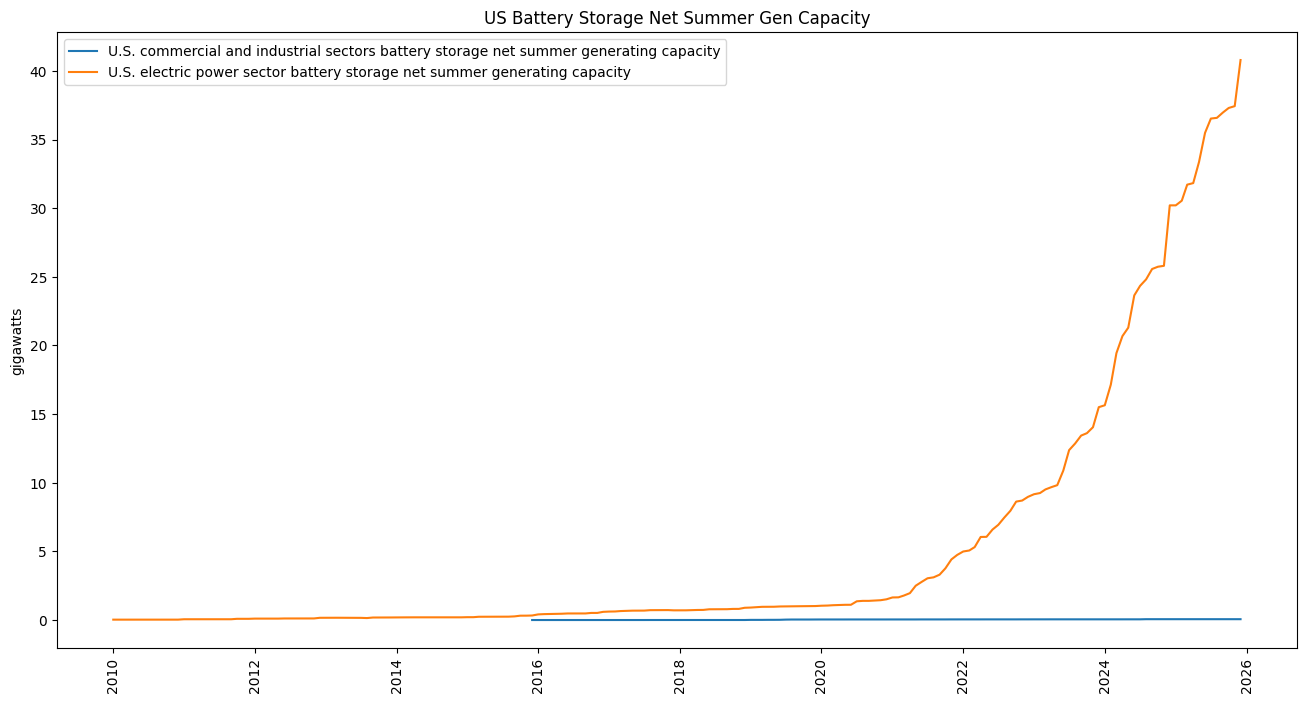

In [9]:
# checking our our data
gimme_lineplot(dataframe=battery_df, 
               title='US Battery Storage Net Summer Gen Capacity')

In [10]:
# testing our function by looking at wind related data from STEO
iso_winds = ["WNEPGEN_MW", "WNEPGEN_NE", "WNEPGEN_NY", "WNEPGEN_PJ", "WNEPGEN_SP", 
           "WNEPGEN_TX"]

start = '2010-01'

# creating a save path for our data
save_date = datetime.date.today().strftime("%Y_%m")

# where we will be storing our data
save_path = f'output/wind/wind_steo_data_{save_date}.csv'

wind_df = series_to_dataframe(series_list=iso_winds, start_date=start, 
                              save_path=save_path, key=api_key)

print(wind_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1152 entries, 0 to 1151
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   period             1152 non-null   datetime64[ns]
 1   seriesId           1152 non-null   object        
 2   seriesDescription  1152 non-null   object        
 3   value              1152 non-null   float64       
 4   unit               1152 non-null   object        
 5   forecast_period    1152 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(1), object(3)
memory usage: 54.1+ KB
None


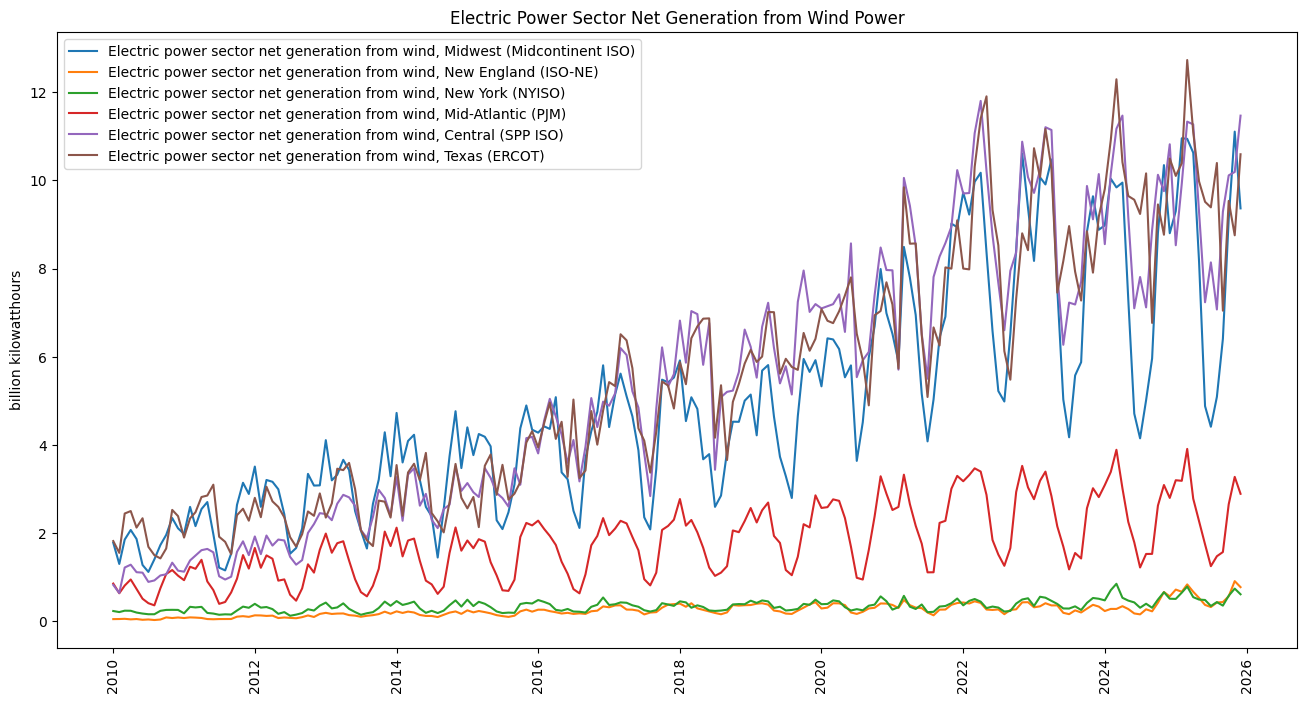

In [11]:
# checking our our data
gimme_lineplot(dataframe=wind_df, 
               title='Electric Power Sector Net Generation from Wind Power')

In [12]:
# electric power sector net generation from solar per each ISO
iso_solars = ["SOEPGEN_MW",
            "SOEPGEN_NE",
            "SOEPGEN_NY",
            "SOEPGEN_PJ",
            "SOEPGEN_SP",
            "SOEPGEN_TX"]

start = '2010-01'

# creating a save path for our data
save_date = datetime.date.today().strftime("%Y_%m")

# where we will be storing our data
save_path = f'output/solar/solar_steo_data_{save_date}.csv'
print(save_path[-11:-4])

solar_df = series_to_dataframe(series_list=iso_solars, start_date=start, 
                              save_path=save_path, key=api_key)

print(solar_df.info())

2024_03
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1152 entries, 0 to 1151
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   period             1152 non-null   datetime64[ns]
 1   seriesId           1152 non-null   object        
 2   seriesDescription  1152 non-null   object        
 3   value              1152 non-null   float64       
 4   unit               1152 non-null   object        
 5   forecast_period    1152 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(1), object(3)
memory usage: 54.1+ KB
None


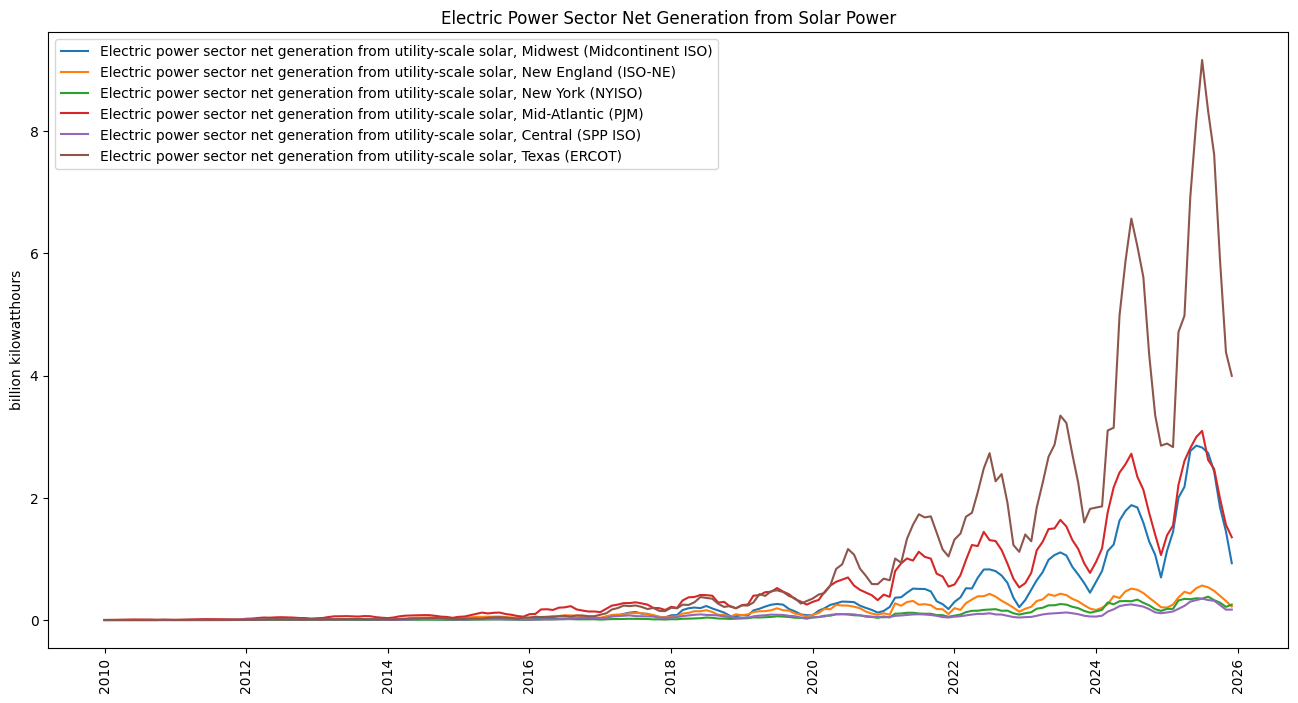

In [13]:
# checking our our data
gimme_lineplot(dataframe=solar_df, 
               title='Electric Power Sector Net Generation from Solar Power')

In [14]:
# retail sales of electricity in transportation sector by region
transportation_electricity = [
    "ELACP_ENC",
    "ELACP_ESC",
    "ELACP_HAK",
    "ELACP_MAC",
    "ELACP_MTN",
    "ELACP_NEC",
    "ELACP_PAC",
    "ELACP_SAC",
    "ELACP_WNC",
    "ELACP_WSC"]

start = '2010-01'

# creating a save path for our data
save_date = datetime.date.today().strftime("%Y_%m")

# where we will be storing our data
save_path = f'output/transportation/transportation_steo_data_{save_date}.csv'

tran_elec_df = series_to_dataframe(series_list=transportation_electricity, start_date=start, 
                              save_path=save_path, key=api_key)

print(tran_elec_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1920 entries, 0 to 1919
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   period             1920 non-null   datetime64[ns]
 1   seriesId           1920 non-null   object        
 2   seriesDescription  1920 non-null   object        
 3   value              1920 non-null   float64       
 4   unit               1920 non-null   object        
 5   forecast_period    1920 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(1), object(3)
memory usage: 90.1+ KB
None


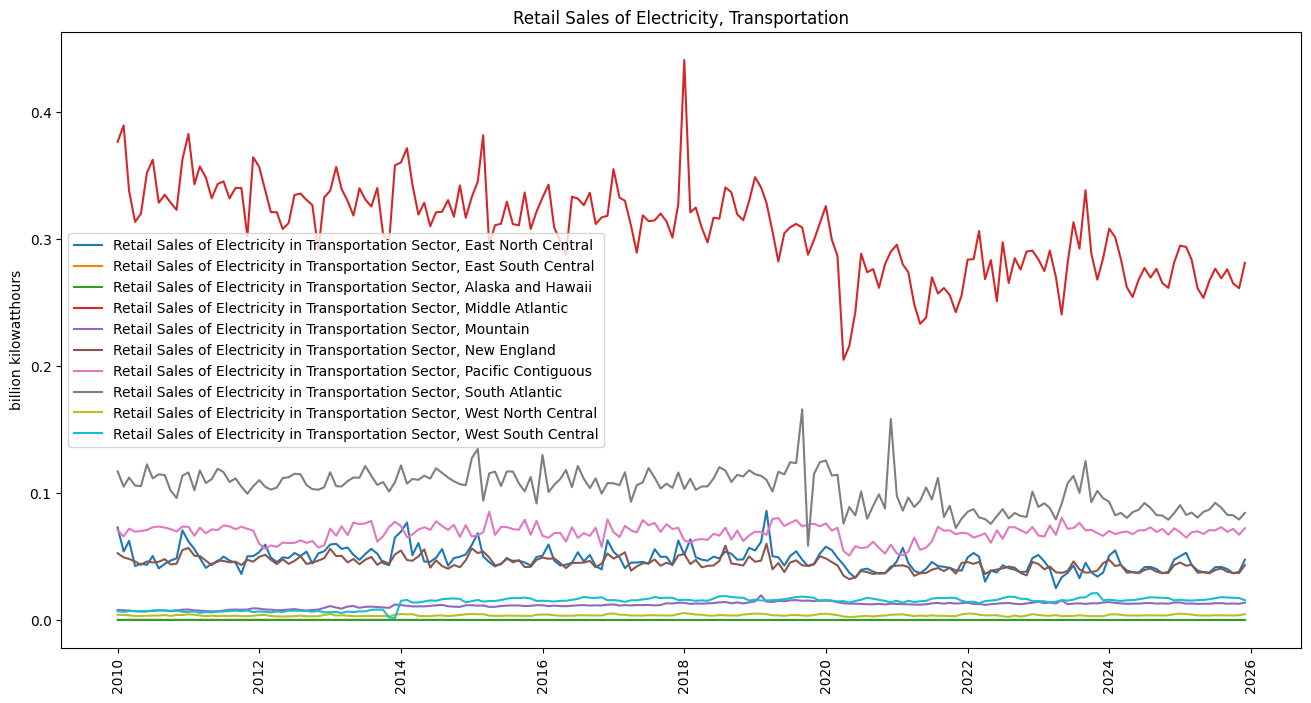

In [15]:
# checking our our data
gimme_lineplot(dataframe=tran_elec_df, 
               title='Retail Sales of Electricity, Transportation')

In [16]:
# Total Consumption of Renewable Energy by Sector
renewables_consumption = [
    "REACBUS",
    "RECCBUS",
    "REECBUS",
    "REICBUS",
    "RERCBUS",
    "REXCBUS"]

start = '2010-01'

# creating a save path for our data
save_date = datetime.date.today().strftime("%Y_%m")

# where we will be storing our data
save_path = f'output/renewables/renewables_steo_data_{save_date}.csv'

renewables_df = series_to_dataframe(series_list=renewables_consumption, start_date=start, 
                              save_path=save_path, key=api_key)

print(renewables_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1152 entries, 0 to 1151
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   period             1152 non-null   datetime64[ns]
 1   seriesId           1152 non-null   object        
 2   seriesDescription  1152 non-null   object        
 3   value              1152 non-null   float64       
 4   unit               1152 non-null   object        
 5   forecast_period    1152 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(1), object(3)
memory usage: 54.1+ KB
None


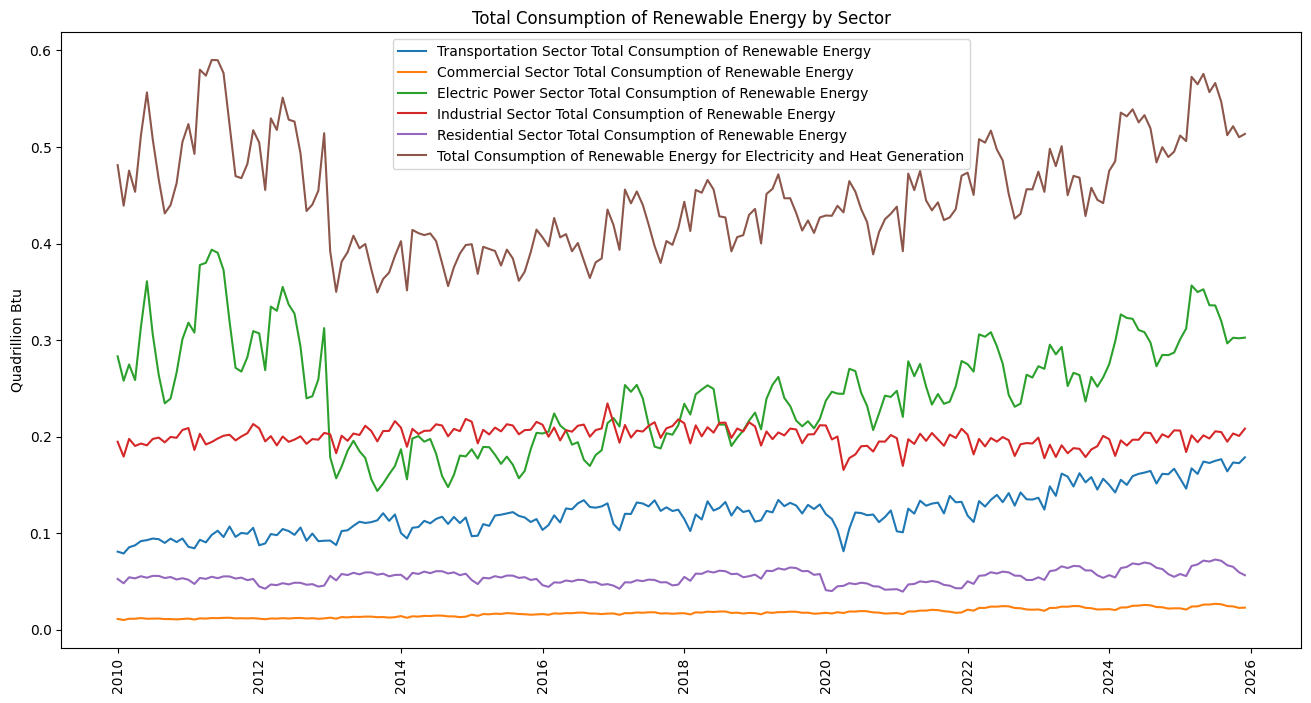

In [17]:
# checking our our data
gimme_lineplot(dataframe=renewables_df, 
               title='Total Consumption of Renewable Energy by Sector')

In [18]:
# Cooling Degree Days by Region
cooling_degree_days = [
   # "ZWCDPUS",
    "ZWCD_ENC",
    "ZWCD_ESC",
    "ZWCD_MAC",
    "ZWCD_MTN",
    "ZWCD_NEC",
    "ZWCD_PAC",
    "ZWCD_SAC",
    "ZWCD_WNC",
    "ZWCD_WSC"]

start = '2010-01'

# creating a save path for our data
save_date = datetime.date.today().strftime("%Y_%m")

# where we will be storing our data
save_path = f'output/weather/cdd_steo_data_{save_date}.csv'

cdd_df = series_to_dataframe(series_list=cooling_degree_days, start_date=start, 
                              save_path=save_path, key=api_key)

print(cdd_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   period             1728 non-null   datetime64[ns]
 1   seriesId           1728 non-null   object        
 2   seriesDescription  1728 non-null   object        
 3   value              1728 non-null   float64       
 4   unit               1728 non-null   object        
 5   forecast_period    1728 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(1), object(3)
memory usage: 81.1+ KB
None


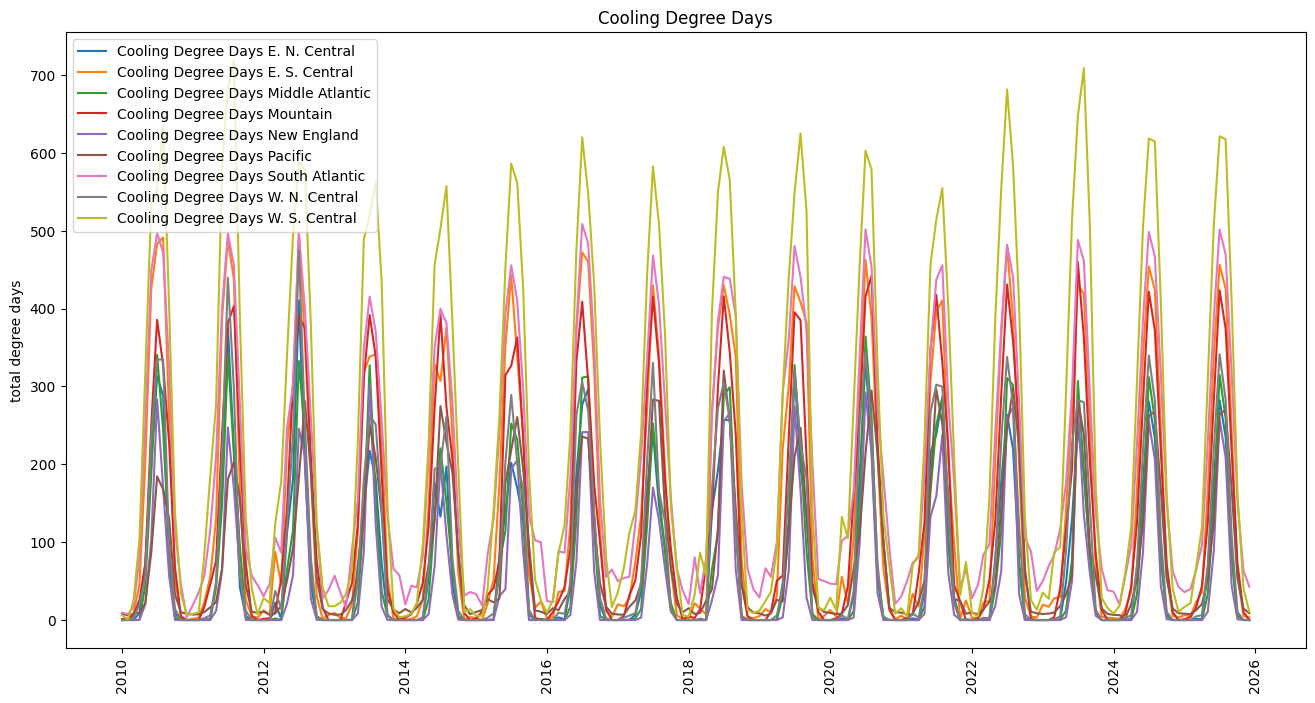

In [19]:
# checking our our data
gimme_lineplot(dataframe=cdd_df, 
               title='Cooling Degree Days')

In [20]:
# Heating Degree Days by Region
heating_degree_days = [
        #"ZWHDPUS",
        #"ZWHDPUS_PCT",
        "ZWHD_ENC",
        #"ZWHD_ENC_10YR",
        "ZWHD_ESC",
        #"ZWHD_ESC_10YR",
        "ZWHD_MAC",
        #"ZWHD_MAC_10YR",
        "ZWHD_MTN",
        #"ZWHD_MTN_10YR",
        "ZWHD_NEC",
        #"ZWHD_NEC_10YR",
        "ZWHD_PAC",
        #"ZWHD_PAC_10YR",
        "ZWHD_SAC",
        #"ZWHD_SAC_10YR",
        #"ZWHD_US_10YR",
        "ZWHD_WNC",
        #"ZWHD_WNC_10YR",
        "ZWHD_WSC",
        #"ZWHD_WSC_10YR"
        ]

start = '2010-01'

# creating a save path for our data
save_date = datetime.date.today().strftime("%Y_%m")

# where we will be storing our data
save_path = f'output/weather/hdd_steo_data_{save_date}.csv'

hdd_df = series_to_dataframe(series_list=heating_degree_days, start_date=start, 
                              save_path=save_path, key=api_key)

print(hdd_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   period             1728 non-null   datetime64[ns]
 1   seriesId           1728 non-null   object        
 2   seriesDescription  1728 non-null   object        
 3   value              1728 non-null   float64       
 4   unit               1728 non-null   object        
 5   forecast_period    1728 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(1), object(3)
memory usage: 81.1+ KB
None


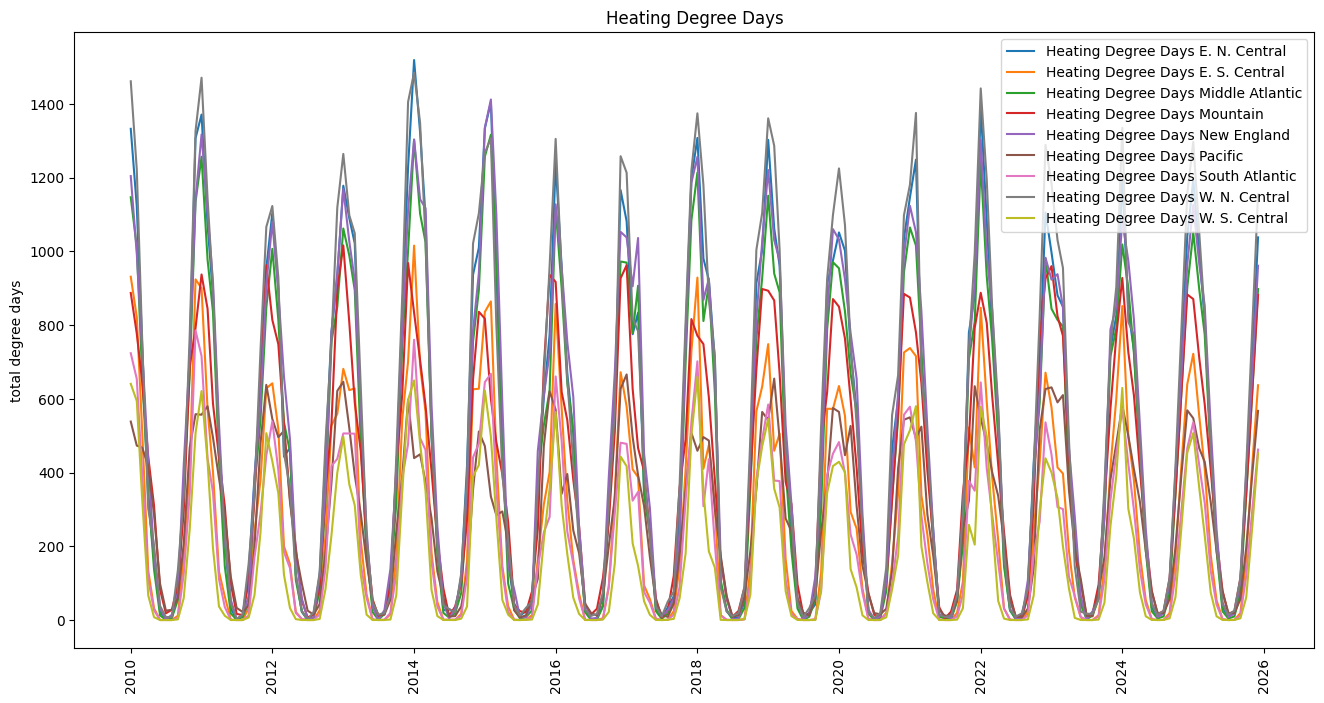

In [21]:
# checking our our data
gimme_lineplot(dataframe=hdd_df, 
               title='Heating Degree Days')

In [22]:
# Carbon Dioxide emissions by source
emissions = [
        "CXTCCO2",
        "FFTCCO2",
        "NGTCCO2",
        "PATCCO2"]

start = '2010-01'

# creating a save path for our data
save_date = datetime.date.today().strftime("%Y_%m")

# where we will be storing our data
save_path = f'output/emissions/emissions_steo_data_{save_date}.csv'

emissions_df = series_to_dataframe(series_list=emissions, start_date=start, 
                              save_path=save_path, key=api_key)

print(emissions_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   period             768 non-null    datetime64[ns]
 1   seriesId           768 non-null    object        
 2   seriesDescription  768 non-null    object        
 3   value              768 non-null    float64       
 4   unit               768 non-null    object        
 5   forecast_period    768 non-null    datetime64[ns]
dtypes: datetime64[ns](2), float64(1), object(3)
memory usage: 36.1+ KB
None


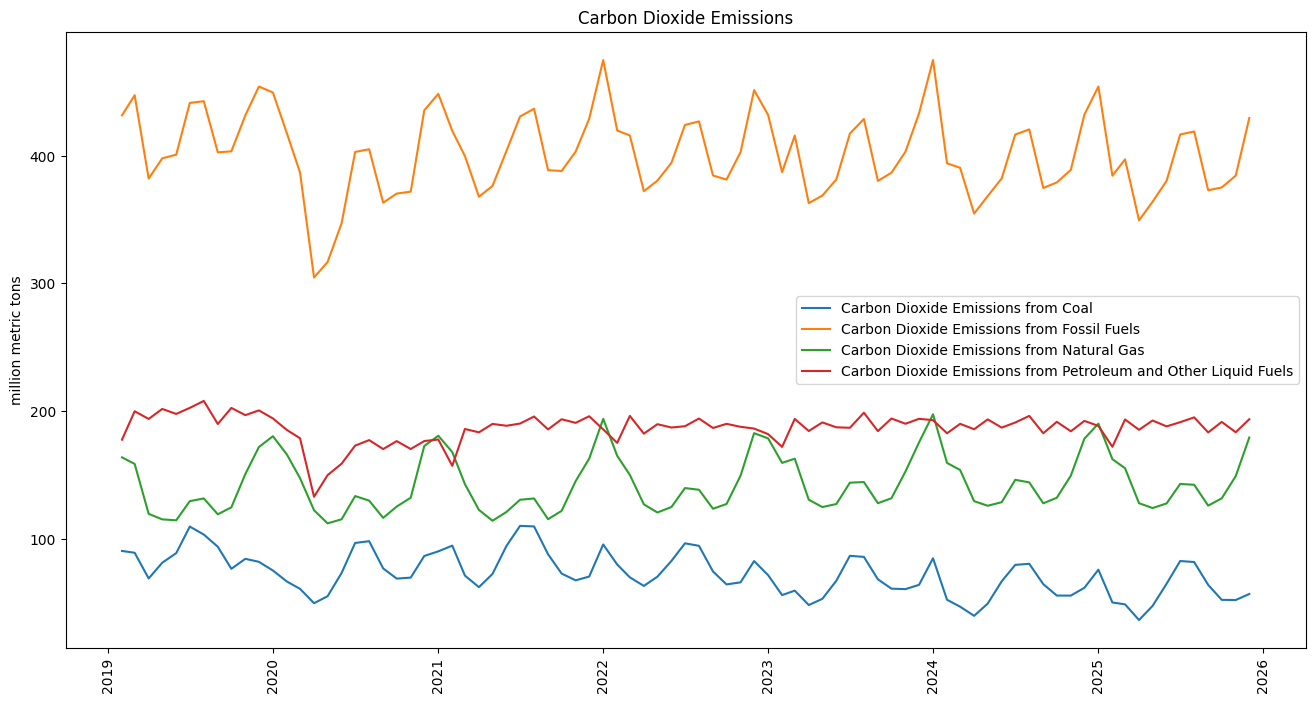

In [23]:
# checking our our data
gimme_lineplot(dataframe=emissions_df[emissions_df['period'] > '1/1/2019'], 
               title='Carbon Dioxide Emissions')


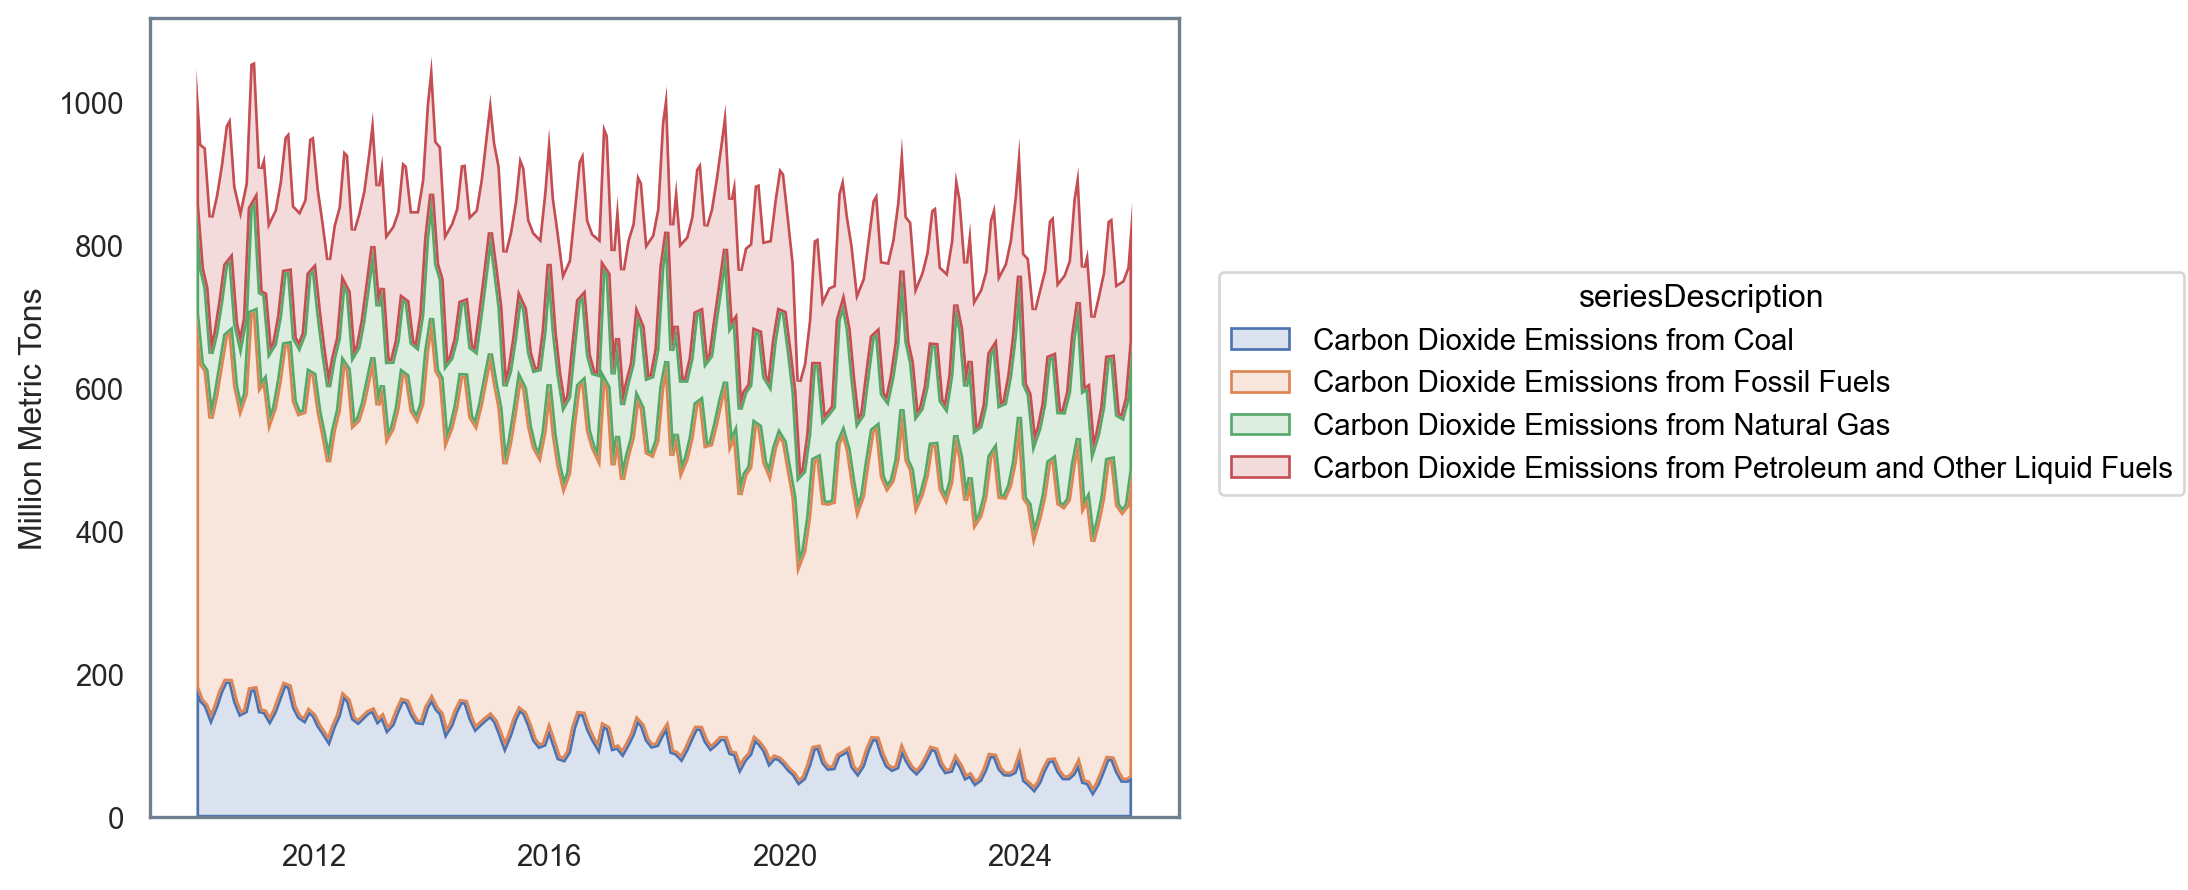

In [24]:
theme_dict = {**axes_style("white"), "axes.edgecolor":"slategray"}
so.Plot.config.theme.update(theme_dict)

# creating a stacked area chart
em_data = emissions_df[emissions_df['period'] >= '1/1/2010']

p = (
    so.Plot(em_data, x='period', y='value').add(so.Area(), so.Stack(), color='seriesDescription')
)

# Labels
p.label(x=None, y="Million Metric Tons")



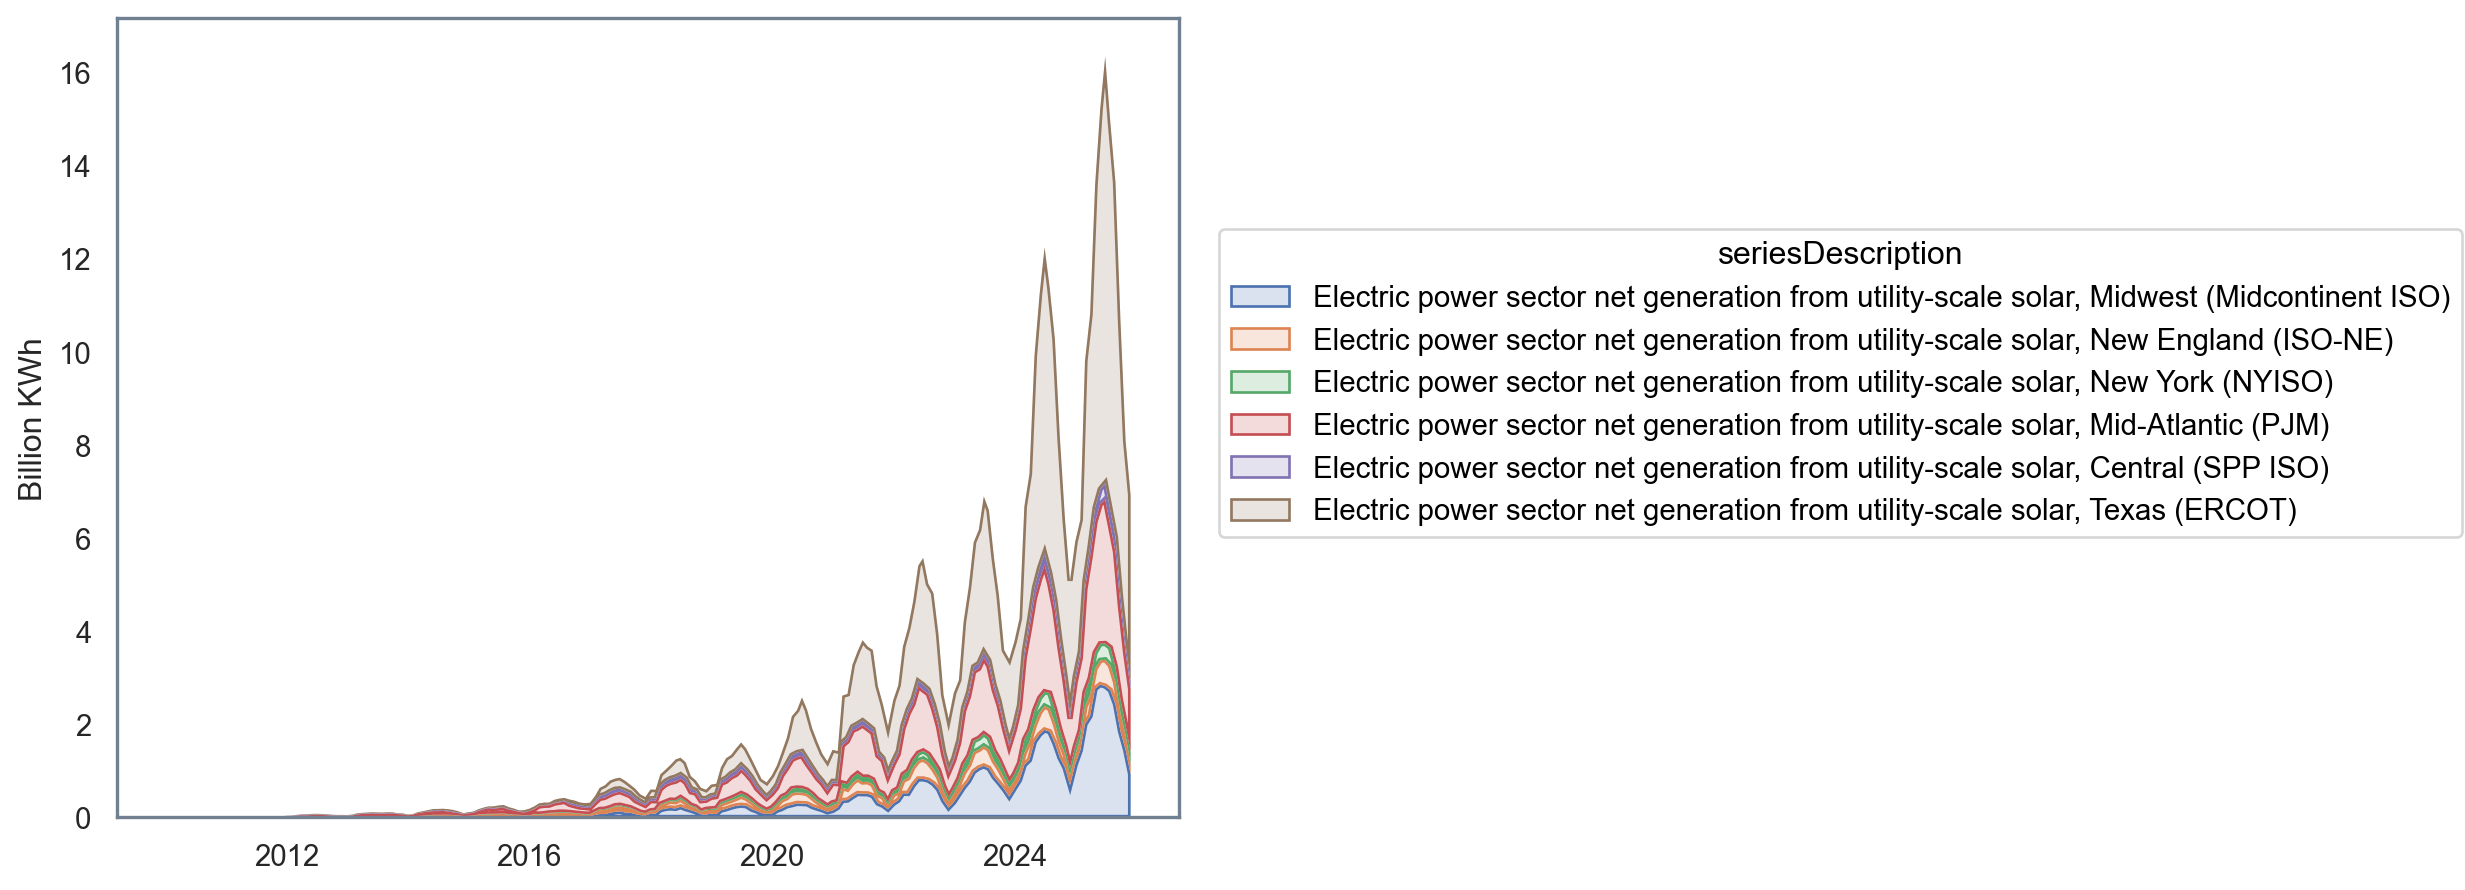

In [25]:
theme_dict = {**axes_style("white"), "axes.edgecolor":"slategray"}
so.Plot.config.theme.update(theme_dict)

# creating a stacked area chart
solar_data = solar_df[solar_df['period'] >= '1/1/2010']

p = (
    so.Plot(solar_data, x='period', y='value').add(so.Area(), so.Stack(), color='seriesDescription')
)

# Labels
p.label(x=None, y="Billion KWh")

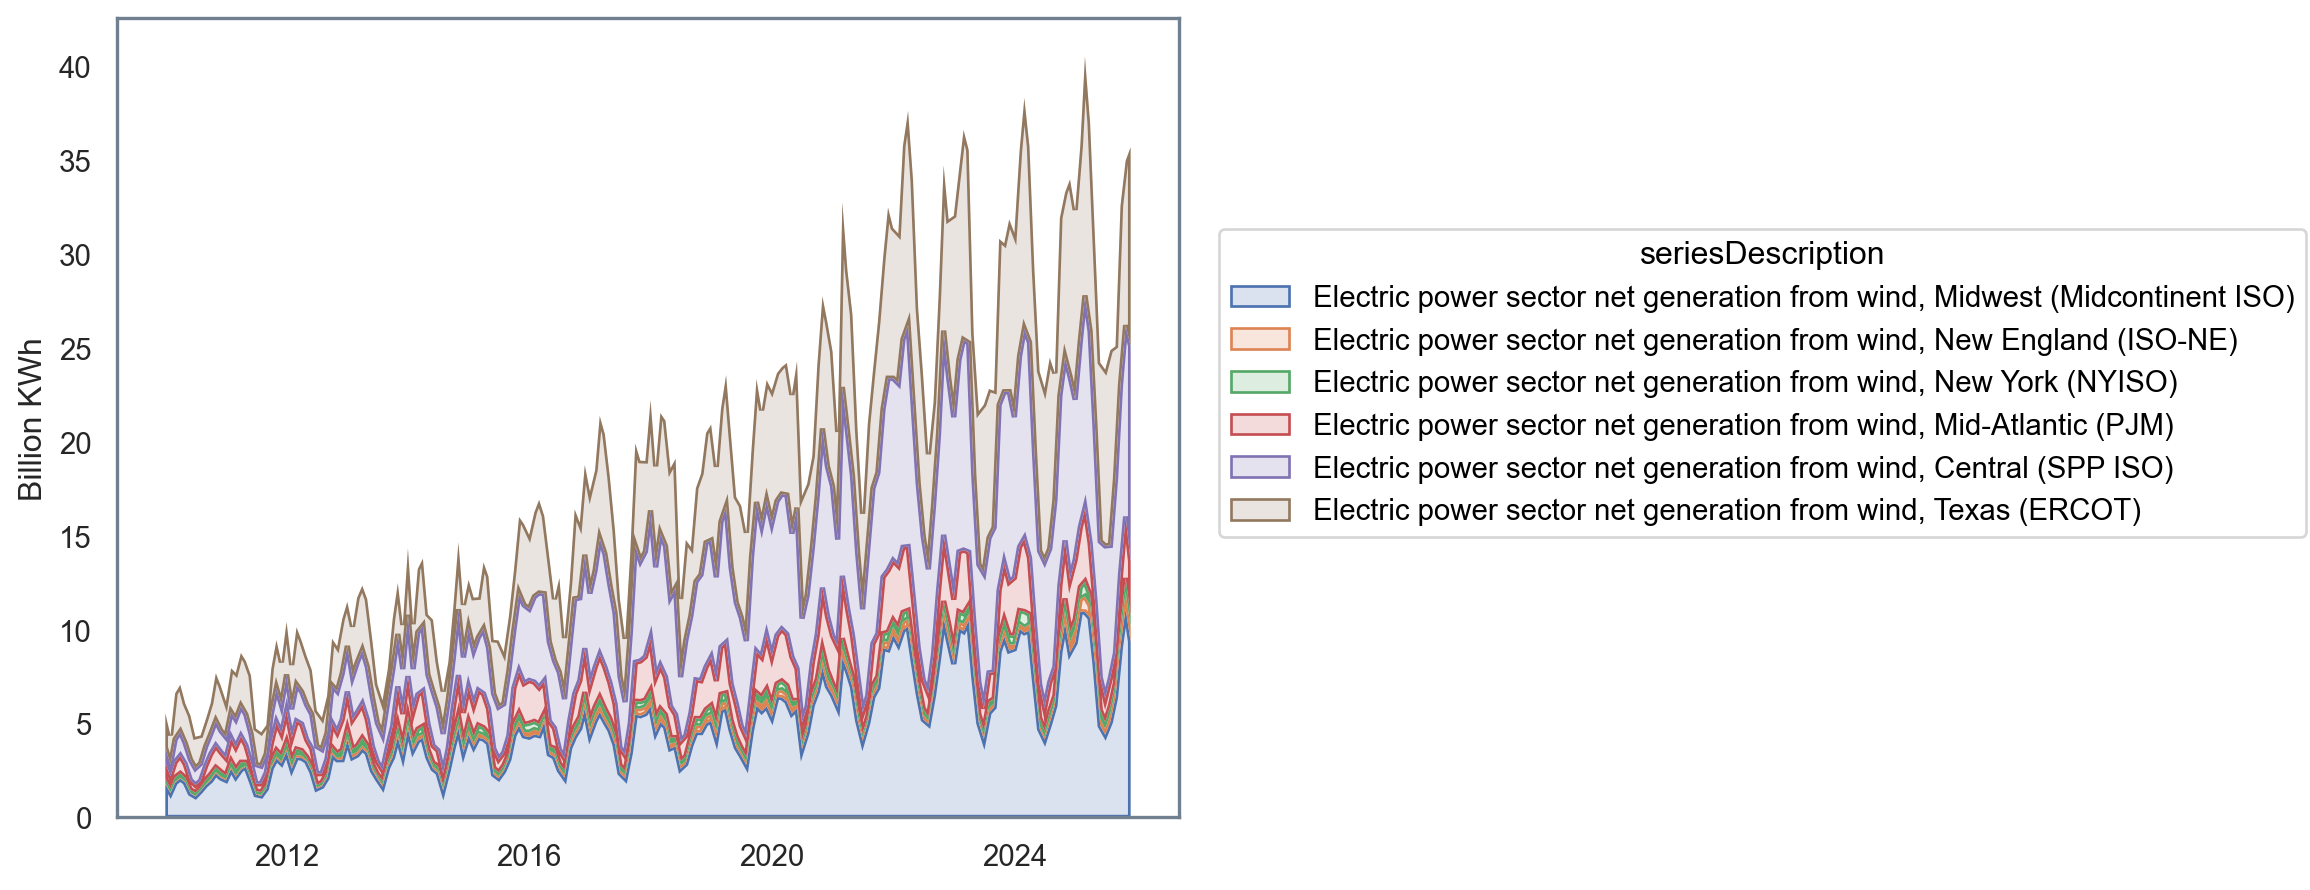

In [26]:
theme_dict = {**axes_style("white"), "axes.edgecolor":"slategray"}
so.Plot.config.theme.update(theme_dict)

# creating a stacked area chart
wind_data = wind_df[wind_df['period'] >= '1/1/2010']

p = (
    so.Plot(wind_data, x='period', y='value').add(so.Area(), so.Stack(), color='seriesDescription')
)

# Labels
p.label(x=None, y="Billion KWh")

In [27]:
# PURPOSE IS TO RETURN AREA PLOT
def gimme_area_plot(dataframe, y_lab, x_lab=None):

    theme_dict = {**axes_style("white"), "axes.edgecolor":"slategray"}
    so.Plot.config.theme.update(theme_dict)

    p = (
        so.Plot(dataframe, x='period', y='value')
        .add(so.Area(), so.Stack(), color='seriesDescription')
    )

    p.label(x=x_lab, y=y_lab)
    p.show()

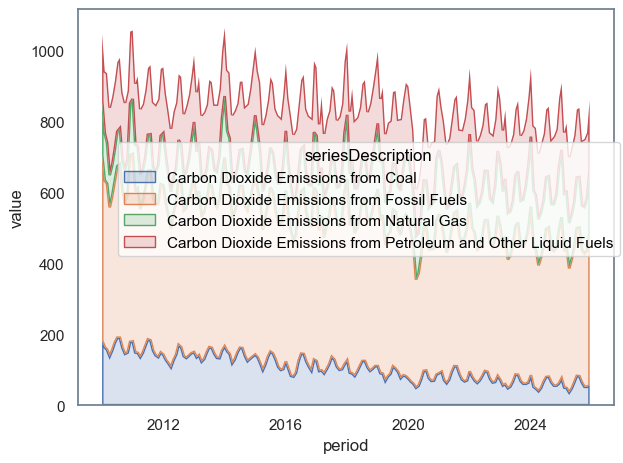

In [28]:
gimme_area_plot(dataframe=em_data, y_lab="Million Metric Tons")

In [29]:
strings = 'output/battery/battery_data_2024_02.csv'


print(strings[-6:-4])

02
